In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-22 08:36:48.467794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 08:36:48.467850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
13/13 [==============================] - 1s 29ms/step - loss: 2.0277 - accuracy: 0.0408 - val_loss: 1.9347 - val_accuracy: 0.0185
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 1.8284 - accuracy: 0.1837 - val_loss: 1.8820 - val_accuracy: 0.0185
Epoch 3/150
13/13 [==============================] - 0s 5ms/step - loss: 1.8109 - accuracy: 0.2245 - val_loss: 1.8359 - val_accuracy: 0.0185
Epoch 4/150
13/13 [==============================] - 0s 5ms/step - loss: 1.7644 - accuracy: 0.2041 - val_loss: 1.7923 - val_accuracy: 0.0185
Epoch 5/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7600 - accuracy: 0.2653 - val_loss: 1.7508 - val_accuracy: 0.3148
Epoch 6/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7053 - accuracy: 0.3469 - val_loss: 1.7132 - val_accuracy: 0.6111
Epoch 7/150
13/13 [==============================] - 0s 8ms/step - loss: 1.6439 - accuracy: 0.3878 - val_loss: 1.6767 - val_accuracy: 0.6296
Epoch 8/150


Epoch 59/150
13/13 [==============================] - 0s 9ms/step - loss: 0.7841 - accuracy: 0.7347 - val_loss: 0.7968 - val_accuracy: 0.7037
Epoch 60/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7570 - accuracy: 0.7755 - val_loss: 0.7875 - val_accuracy: 0.7037
Epoch 61/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8005 - accuracy: 0.7347 - val_loss: 0.7776 - val_accuracy: 0.7222
Epoch 62/150
13/13 [==============================] - 0s 5ms/step - loss: 0.7316 - accuracy: 0.7959 - val_loss: 0.7682 - val_accuracy: 0.7222
Epoch 63/150
13/13 [==============================] - 0s 6ms/step - loss: 0.6730 - accuracy: 0.8163 - val_loss: 0.7591 - val_accuracy: 0.7222
Epoch 64/150
13/13 [==============================] - 0s 6ms/step - loss: 0.7544 - accuracy: 0.7347 - val_loss: 0.7514 - val_accuracy: 0.7222
Epoch 65/150
13/13 [==============================] - 0s 5ms/step - loss: 0.8373 - accuracy: 0.6939 - val_loss: 0.7450 - val_accuracy: 0.7222
Epoch 

13/13 [==============================] - 0s 5ms/step - loss: 0.5006 - accuracy: 0.8163 - val_loss: 0.4774 - val_accuracy: 0.8519
Epoch 117/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5327 - accuracy: 0.8163 - val_loss: 0.4740 - val_accuracy: 0.8519
Epoch 118/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5087 - accuracy: 0.8571 - val_loss: 0.4692 - val_accuracy: 0.8519
Epoch 119/150
13/13 [==============================] - 0s 8ms/step - loss: 0.5538 - accuracy: 0.7755 - val_loss: 0.4635 - val_accuracy: 0.8704
Epoch 120/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5100 - accuracy: 0.8776 - val_loss: 0.4590 - val_accuracy: 0.8704
Epoch 121/150
13/13 [==============================] - 0s 6ms/step - loss: 0.5331 - accuracy: 0.7959 - val_loss: 0.4554 - val_accuracy: 0.8704
Epoch 122/150
13/13 [==============================] - 0s 5ms/step - loss: 0.4679 - accuracy: 0.8776 - val_loss: 0.4517 - val_accuracy: 0.8704
Epoch 123/150

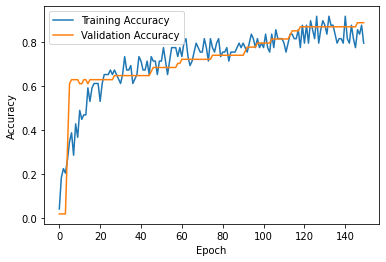

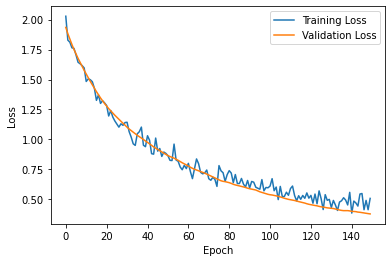

Best validation accuracy: 0.8888888955116272
Training accuracy at the best test accuracy: 0.8571428656578064
Best validation accuracy: 0.8888888955116272
Training accuracy at the best test accuracy: 0.8571428656578064
Confusion matrix:
[[12  0  0  0  0  0]
 [ 1  3  0  0  0  0]
 [ 0  0  2  1  0  0]
 [ 0  0  0 21  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 92.3076923076923
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 80.76923076923077
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9551282051282052
Total Recall: 0.8194444444444443
Total F1 Score: 0.86290442418102
Accuracy for each label: [ 92.30769231 100.         100.          80.76923077 100.
 100.        ]
Precision for each label: [0.92307692 1.         1.         0.80769231 1.         1.        ]
Recall for each label: [1.         0.75       0.66666667 1.         1.         0.5       ]
F1 Score for each label: [0.96       0.85714286 0.8        0.89361702 1.         0.66666667

In [14]:
run_model(ratio_1, callback_1)

/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
15/15 [==============================] - 1s 21ms/step - loss: 1.8557 - accuracy: 0.2000 - val_loss: 1.9413 - val_accuracy: 0.2791
Epoch 2/150
15/15 [==============================] - 0s 7ms/step - loss: 1.7209 - accuracy: 0.2833 - val_loss: 1.8724 - val_accuracy: 0.3953
Epoch 3/150
15/15 [==============================] - 0s 7ms/step - loss: 1.6202 - accuracy: 0.3667 - val_loss: 1.8104 - val_accuracy: 0.5116
Epoch 4/150
15/15 [==============================] - 0s 7ms/step - loss: 1.5869 - accuracy: 0.4000 - val_loss: 1.7546 - val_accuracy: 0.6047
Epoch 5/150
15/15 [==============================] - 0s 7ms/step - loss: 1.5925 - accuracy: 0.3333 - val_loss: 1.7041 - val_accuracy: 0.6512
Epoch 6/150
15/15 [==============================] - 0s 4ms/step - loss: 1.5098 - accuracy: 0.4500 - val_loss: 1.6512 - val_accuracy: 0.6512
Epoch 7/150
15/15 [==============================] - 0s 7ms/step - loss: 1.4146 - accuracy: 0.5833 - val_loss: 1.6003 - val_accuracy: 0.6744
Epoch 8/150


Epoch 59/150
15/15 [==============================] - 0s 5ms/step - loss: 0.7158 - accuracy: 0.7000 - val_loss: 0.7046 - val_accuracy: 0.7209
Epoch 60/150
15/15 [==============================] - 0s 5ms/step - loss: 0.6706 - accuracy: 0.7667 - val_loss: 0.6944 - val_accuracy: 0.7209
Epoch 61/150
15/15 [==============================] - 0s 5ms/step - loss: 0.5833 - accuracy: 0.8000 - val_loss: 0.6839 - val_accuracy: 0.7209
Epoch 62/150
15/15 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.8000 - val_loss: 0.6764 - val_accuracy: 0.7209
Epoch 63/150
15/15 [==============================] - 0s 5ms/step - loss: 0.6746 - accuracy: 0.7500 - val_loss: 0.6659 - val_accuracy: 0.7209
Epoch 64/150
15/15 [==============================] - 0s 4ms/step - loss: 0.7047 - accuracy: 0.7167 - val_loss: 0.6583 - val_accuracy: 0.7209
Epoch 65/150
15/15 [==============================] - 0s 6ms/step - loss: 0.6410 - accuracy: 0.7500 - val_loss: 0.6509 - val_accuracy: 0.7442
Epoch 

15/15 [==============================] - 0s 5ms/step - loss: 0.4497 - accuracy: 0.8000 - val_loss: 0.4615 - val_accuracy: 0.8837
Epoch 117/150
15/15 [==============================] - 0s 4ms/step - loss: 0.5248 - accuracy: 0.8167 - val_loss: 0.4604 - val_accuracy: 0.8837
Epoch 118/150
15/15 [==============================] - 0s 5ms/step - loss: 0.4832 - accuracy: 0.8167 - val_loss: 0.4558 - val_accuracy: 0.8837
Epoch 119/150
15/15 [==============================] - 0s 4ms/step - loss: 0.3648 - accuracy: 0.8833 - val_loss: 0.4504 - val_accuracy: 0.8605
Epoch 120/150
15/15 [==============================] - 0s 5ms/step - loss: 0.3917 - accuracy: 0.8667 - val_loss: 0.4465 - val_accuracy: 0.8605
Epoch 121/150
15/15 [==============================] - 0s 5ms/step - loss: 0.4799 - accuracy: 0.7667 - val_loss: 0.4449 - val_accuracy: 0.8605
Epoch 122/150
15/15 [==============================] - 0s 5ms/step - loss: 0.4010 - accuracy: 0.9000 - val_loss: 0.4402 - val_accuracy: 0.8837
Epoch 123/150

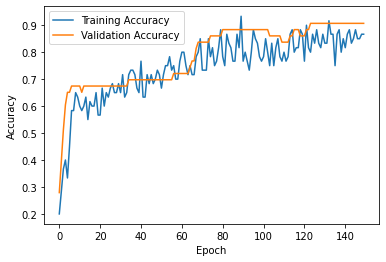

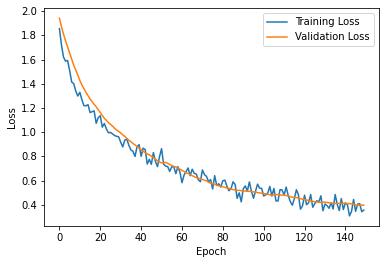

Best validation accuracy: 0.9069767594337463
Training accuracy at the best test accuracy: 0.800000011920929
Best validation accuracy: 0.9069767594337463
Training accuracy at the best test accuracy: 0.800000011920929
Confusion matrix:
[[10  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0 16  0  1]
 [ 0  0  0  0  5  0]
 [ 0  0  0  3  0  3]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 84.21052631578947
Accuracy for 4 : 100.0
Accuracy for 5 : 75.0
Total Precision: 0.9320175438596491
Total Recall: 0.9068627450980392
Total F1 Score: 0.9148148148148149
Accuracy for each label: [100.         100.         100.          84.21052632 100.
  75.        ]
Precision for each label: [1.         1.         1.         0.84210526 1.         0.75      ]
Recall for each label: [1.         1.         1.         0.94117647 1.         0.5       ]
F1 Score for each label: [1.         1.         1.         0.88888889 1.         0.6       ]
Total Accu

In [15]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
18/18 [==============================] - 1s 15ms/step - loss: 1.6373 - accuracy: 0.3043 - val_loss: 1.8093 - val_accuracy: 0.4412
Epoch 2/150
18/18 [==============================] - 0s 6ms/step - loss: 1.6495 - accuracy: 0.3333 - val_loss: 1.7447 - val_accuracy: 0.4706
Epoch 3/150
18/18 [==============================] - 0s 6ms/step - loss: 1.5884 - accuracy: 0.3333 - val_loss: 1.6835 - val_accuracy: 0.5000
Epoch 4/150
18/18 [==============================] - 0s 6ms/step - loss: 1.5695 - accuracy: 0.4783 - val_loss: 1.6288 - val_accuracy: 0.5588
Epoch 5/150
18/18 [==============================] - 0s 6ms/step - loss: 1.5063 - accuracy: 0.4638 - val_loss: 1.5809 - val_accuracy: 0.5882
Epoch 6/150
18/18 [==============================] - 0s 4ms/step - loss: 1.4430 - accuracy: 0.5217 - val_loss: 1.5347 - val_accuracy: 0.5882
Epoch 7/150
18/18 [==============================] - 0s 4ms/step - loss: 1.3548 - accuracy: 0.5362 - val_loss: 1.4906 - val_accuracy: 0.5882
Epoch 8/150


Epoch 59/150
18/18 [==============================] - 0s 4ms/step - loss: 0.5565 - accuracy: 0.8116 - val_loss: 0.5303 - val_accuracy: 0.8529
Epoch 60/150
18/18 [==============================] - 0s 4ms/step - loss: 0.6380 - accuracy: 0.7681 - val_loss: 0.5251 - val_accuracy: 0.8529
Epoch 61/150
18/18 [==============================] - 0s 4ms/step - loss: 0.6184 - accuracy: 0.7391 - val_loss: 0.5170 - val_accuracy: 0.8529
Epoch 62/150
18/18 [==============================] - 0s 4ms/step - loss: 0.5521 - accuracy: 0.8261 - val_loss: 0.5119 - val_accuracy: 0.8529
Epoch 63/150
18/18 [==============================] - 0s 4ms/step - loss: 0.5692 - accuracy: 0.8116 - val_loss: 0.5074 - val_accuracy: 0.8529
Epoch 64/150
18/18 [==============================] - 0s 4ms/step - loss: 0.5095 - accuracy: 0.8551 - val_loss: 0.5002 - val_accuracy: 0.8529
Epoch 65/150
18/18 [==============================] - 0s 3ms/step - loss: 0.5203 - accuracy: 0.8406 - val_loss: 0.4939 - val_accuracy: 0.8529
Epoch 

18/18 [==============================] - 0s 4ms/step - loss: 0.4198 - accuracy: 0.8261 - val_loss: 0.3449 - val_accuracy: 0.8824
Epoch 117/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4216 - accuracy: 0.8406 - val_loss: 0.3437 - val_accuracy: 0.8824
Epoch 118/150
18/18 [==============================] - 0s 3ms/step - loss: 0.3911 - accuracy: 0.8261 - val_loss: 0.3419 - val_accuracy: 0.8824
Epoch 119/150
18/18 [==============================] - 0s 3ms/step - loss: 0.3562 - accuracy: 0.9275 - val_loss: 0.3397 - val_accuracy: 0.8824
Epoch 120/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4334 - accuracy: 0.8116 - val_loss: 0.3364 - val_accuracy: 0.8824
Epoch 121/150
18/18 [==============================] - 0s 3ms/step - loss: 0.4203 - accuracy: 0.8551 - val_loss: 0.3341 - val_accuracy: 0.8824
Epoch 122/150
18/18 [==============================] - 0s 3ms/step - loss: 0.3684 - accuracy: 0.8841 - val_loss: 0.3321 - val_accuracy: 0.8824
Epoch 123/150

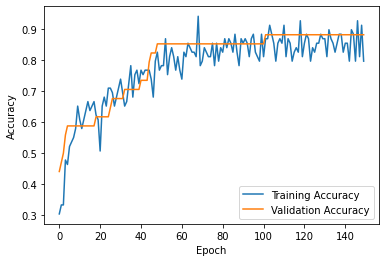

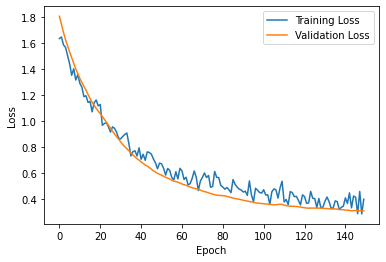

Best validation accuracy: 0.8823529481887817
Training accuracy at the best test accuracy: 0.8695651888847351
Best validation accuracy: 0.8823529481887817
Training accuracy at the best test accuracy: 0.8695651888847351
Confusion matrix:
[[ 7  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  1  1  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  3  0  2]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 76.47058823529412
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9607843137254902
Total Recall: 0.8166666666666668
Total F1 Score: 0.8507936507936508
Accuracy for each label: [100.         100.         100.          76.47058824 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.76470588 1.         1.        ]
Recall for each label: [1.  1.  0.5 1.  1.  0.4]
F1 Score for each label: [1.         1.         0.66666667 0.86666667 1.         0.57142857]
Total Accuracy: 88.23529411764706


In [16]:
run_model(ratio_3, callback_3)

/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
20/20 [==============================] - 1s 13ms/step - loss: 2.0043 - accuracy: 0.2625 - val_loss: 1.8547 - val_accuracy: 0.2609
Epoch 2/150
20/20 [==============================] - 0s 5ms/step - loss: 1.8146 - accuracy: 0.3750 - val_loss: 1.7659 - val_accuracy: 0.3043
Epoch 3/150
20/20 [==============================] - 0s 4ms/step - loss: 1.8473 - accuracy: 0.4250 - val_loss: 1.6882 - val_accuracy: 0.3043
Epoch 4/150
20/20 [==============================] - 0s 5ms/step - loss: 1.6366 - accuracy: 0.5250 - val_loss: 1.6175 - val_accuracy: 0.3913
Epoch 5/150
20/20 [==============================] - 0s 5ms/step - loss: 1.6276 - accuracy: 0.4875 - val_loss: 1.5564 - val_accuracy: 0.4348
Epoch 6/150
20/20 [==============================] - 0s 5ms/step - loss: 1.6088 - accuracy: 0.5125 - val_loss: 1.4940 - val_accuracy: 0.5652
Epoch 7/150
20/20 [==============================] - 0s 4ms/step - loss: 1.5723 - accuracy: 0.4750 - val_loss: 1.4399 - val_accuracy: 0.5652
Epoch 8/150


Epoch 59/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.8250 - val_loss: 0.5025 - val_accuracy: 0.8696
Epoch 60/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6576 - accuracy: 0.7625 - val_loss: 0.5026 - val_accuracy: 0.9130
Epoch 61/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6194 - accuracy: 0.7625 - val_loss: 0.4970 - val_accuracy: 0.9130
Epoch 62/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6388 - accuracy: 0.7750 - val_loss: 0.4902 - val_accuracy: 0.8696
Epoch 63/150
20/20 [==============================] - 0s 3ms/step - loss: 0.6050 - accuracy: 0.8250 - val_loss: 0.4839 - val_accuracy: 0.8696
Epoch 64/150
20/20 [==============================] - 0s 4ms/step - loss: 0.5783 - accuracy: 0.7625 - val_loss: 0.4796 - val_accuracy: 0.8696
Epoch 65/150
20/20 [==============================] - 0s 4ms/step - loss: 0.6152 - accuracy: 0.8000 - val_loss: 0.4736 - val_accuracy: 0.8696
Epoch 

20/20 [==============================] - 0s 3ms/step - loss: 0.4017 - accuracy: 0.8625 - val_loss: 0.3175 - val_accuracy: 0.9130
Epoch 117/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8875 - val_loss: 0.3187 - val_accuracy: 0.9130
Epoch 118/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.8375 - val_loss: 0.3150 - val_accuracy: 0.9130
Epoch 119/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy: 0.8375 - val_loss: 0.3136 - val_accuracy: 0.9130
Epoch 120/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4017 - accuracy: 0.8375 - val_loss: 0.3133 - val_accuracy: 0.9130
Epoch 121/150
20/20 [==============================] - 0s 3ms/step - loss: 0.4099 - accuracy: 0.8625 - val_loss: 0.3121 - val_accuracy: 0.9130
Epoch 122/150
20/20 [==============================] - 0s 4ms/step - loss: 0.4610 - accuracy: 0.8250 - val_loss: 0.3122 - val_accuracy: 0.9130
Epoch 123/150

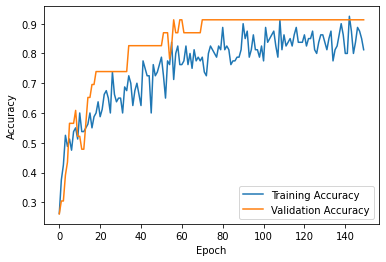

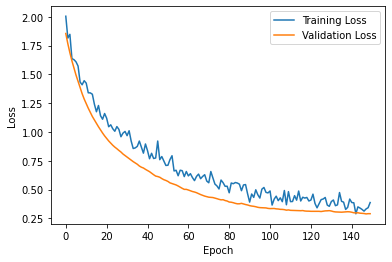

Best validation accuracy: 0.9130434989929199
Training accuracy at the best test accuracy: 0.7124999761581421
Best validation accuracy: 0.9130434989929199
Training accuracy at the best test accuracy: 0.7124999761581421
Confusion matrix:
[[5 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 3 0]
 [0 0 0 2 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 81.81818181818183
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9696969696969697
Total Recall: 0.8888888888888888
Total F1 Score: 0.9
Accuracy for each label: [100.         100.         100.          81.81818182 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.81818182 1.         1.        ]
Recall for each label: [1.         1.         1.         1.         1.         0.33333333]
F1 Score for each label: [1.  1.  1.  0.9 1.  0.5]
Total Accuracy: 91.30434782608695


In [17]:
run_model(ratio_4, callback_4)

/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_85278/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_85278/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
23/23 [==============================] - 1s 11ms/step - loss: 1.9031 - accuracy: 0.2135 - val_loss: 1.8682 - val_accuracy: 0.3571
Epoch 2/150
23/23 [==============================] - 0s 4ms/step - loss: 1.8177 - accuracy: 0.3146 - val_loss: 1.7818 - val_accuracy: 0.4286
Epoch 3/150
23/23 [==============================] - 0s 4ms/step - loss: 1.6814 - accuracy: 0.3820 - val_loss: 1.6997 - val_accuracy: 0.5714
Epoch 4/150
23/23 [==============================] - 0s 3ms/step - loss: 1.7177 - accuracy: 0.4157 - val_loss: 1.6334 - val_accuracy: 0.5714
Epoch 5/150
23/23 [==============================] - 0s 3ms/step - loss: 1.6196 - accuracy: 0.5169 - val_loss: 1.5733 - val_accuracy: 0.5714
Epoch 6/150
23/23 [==============================] - 0s 3ms/step - loss: 1.5598 - accuracy: 0.5281 - val_loss: 1.5196 - val_accuracy: 0.5714
Epoch 7/150
23/23 [==============================] - 0s 3ms/step - loss: 1.5611 - accuracy: 0.5056 - val_loss: 1.4646 - val_accuracy: 0.5714
Epoch 8/150


Epoch 59/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.7528 - val_loss: 0.5110 - val_accuracy: 0.9286
Epoch 60/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.7528 - val_loss: 0.5019 - val_accuracy: 0.9286
Epoch 61/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6368 - accuracy: 0.7640 - val_loss: 0.5026 - val_accuracy: 0.9286
Epoch 62/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5943 - accuracy: 0.7640 - val_loss: 0.4949 - val_accuracy: 0.9286
Epoch 63/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6098 - accuracy: 0.7865 - val_loss: 0.4855 - val_accuracy: 0.9286
Epoch 64/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5930 - accuracy: 0.8090 - val_loss: 0.4798 - val_accuracy: 0.9286
Epoch 65/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6109 - accuracy: 0.7865 - val_loss: 0.4817 - val_accuracy: 0.9286
Epoch 

23/23 [==============================] - 0s 3ms/step - loss: 0.3984 - accuracy: 0.8427 - val_loss: 0.3966 - val_accuracy: 0.9286
Epoch 117/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3857 - accuracy: 0.8539 - val_loss: 0.3900 - val_accuracy: 0.9286
Epoch 118/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4190 - accuracy: 0.8427 - val_loss: 0.3888 - val_accuracy: 0.9286
Epoch 119/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4315 - accuracy: 0.7978 - val_loss: 0.3919 - val_accuracy: 0.9286
Epoch 120/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy: 0.8315 - val_loss: 0.3894 - val_accuracy: 0.9286
Epoch 121/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4199 - accuracy: 0.8315 - val_loss: 0.3816 - val_accuracy: 0.9286
Epoch 122/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4777 - accuracy: 0.7753 - val_loss: 0.3767 - val_accuracy: 0.9286
Epoch 123/150

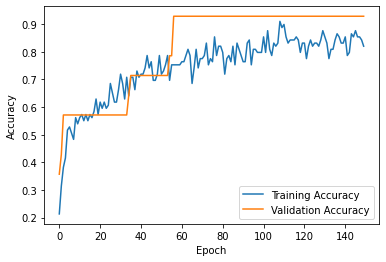

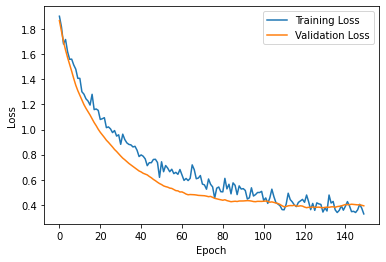

Best validation accuracy: 0.9285714030265808
Training accuracy at the best test accuracy: 0.7528089880943298
Best validation accuracy: 0.9285714030265808
Training accuracy at the best test accuracy: 0.7528089880943298
Confusion matrix:
[[3 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 2 0]
 [0 0 0 1 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9722222222222223
Total Recall: 0.9166666666666666
Total F1 Score: 0.9292929292929294
Accuracy for each label: [100.         100.         100.          83.33333333 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.83333333 1.         1.        ]
Recall for each label: [1.  1.  1.  1.  1.  0.5]
F1 Score for each label: [1.         1.         1.         0.90909091 1.         0.66666667]
Total Accuracy: 92.85714285714286


In [18]:
run_model(ratio_5, callback_5)

# 

# N